# Create Atmospheric mask for just Central Arctic Ocean non-land points

* **Description**: creates netcdf of atmospheric mask
* **Input data**: Rufmod atm output in timeseries format
* **Output data**: netcdf
* **Creator**: Alice DuVivier
* **Date**: August 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
from datetime import timedelta
import glob

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec

import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import geocat.comp as gcomp

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress,pearsonr, t


## Manually set variables

In [2]:
# list the variables to load
var_in_1 = 'U10'

## Load smooth experiments

In [3]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/projects/arctic_cyclones/rufmod_expts/'
# set individual data directories
data_dir1 = data_dir+case1+'/atm/proc/tseries/month_1/'

In [4]:
%%time
#reading in files
print("loading "+var_in_1)   
ds1_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cam.h0.'+var_in_1+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')


loading U10
CPU times: user 73.7 ms, sys: 15.3 ms, total: 89 ms
Wall time: 135 ms


In [5]:
# concatenate them into a single array
futures_1 = ds1_1

In [6]:
futures_1

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (time, zlon, nbnd) float64 dask.array<chunksize=(600, 1, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(600, 192), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(600, 32), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(600, 32), meta=np.ndarray>
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai          (time, ilev) float64 dask.array<chunksize=(600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    U10           (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [7]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures_1['time'] = futures_1.time_bnds.load().mean(dim='nbnd')

In [8]:
futures_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:  time interval endpoints

In [9]:
data = futures_1[var_in_1]

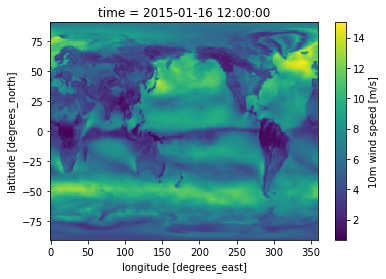

In [10]:
data.isel(time=0).plot()

# Mask Just Arctic Ocean

In [11]:
# Load a Landfrac mask
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/b.e21.BSSP370.f09_g17.rufmod.001.cam.h0.2015-01.nc')
my_mask = ds_masks['LANDFRAC'].isel(time=0)

In [12]:
# create mask for Arctic Ocean grouping
ArcOc_mask = data.isel(time=0)
ArcOc_mask = ArcOc_mask.where(ArcOc_mask>0.0,0)
ArcOc_mask = ArcOc_mask.where(ArcOc_mask==0,1)


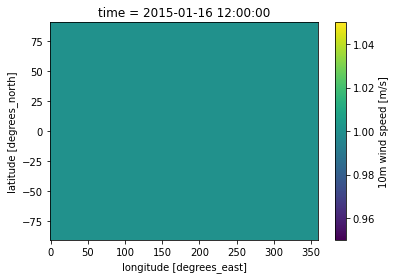

In [13]:
ArcOc_mask.plot()

In [14]:
# Use Marika's lat/lon ranges for three regions and then combine all three into one mask:
region_1 = ArcOc_mask.where((ArcOc_mask['lat']>=80.0) & (ArcOc_mask['lon']>=243) &(ArcOc_mask['lon']<=360))
region_2 = ArcOc_mask.where((ArcOc_mask['lat']>=80.0) & (ArcOc_mask['lon']>=0) &(ArcOc_mask['lon']<=100))
region_3 = ArcOc_mask.where((ArcOc_mask['lat']>=68.0) & (ArcOc_mask['lon']>100) &(ArcOc_mask['lon']<=243))

# reset Arctic Ocean Mask
ArcOc_mask = region_1.fillna(0)+region_2.fillna(0)+region_3.fillna(0)

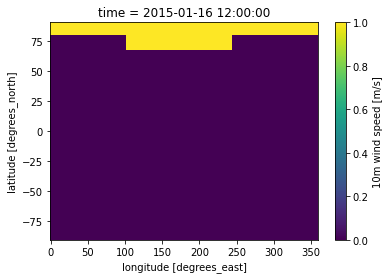

In [15]:
ArcOc_mask.plot()

In [16]:
#mask data using just ArcOc ocean points and over ocean only
atm_ArcOc_mask = ArcOc_mask.where((ArcOc_mask==1) & (my_mask<0.5))

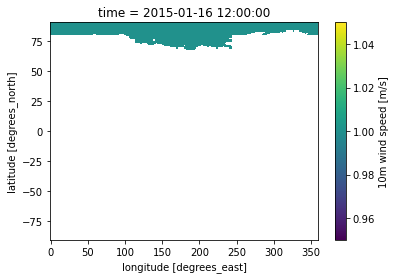

In [17]:
atm_ArcOc_mask.plot()

## Plot to verify it worked correctly

In [18]:
# mask data using mask we just created
data_masked = data.where(atm_ArcOc_mask==1)

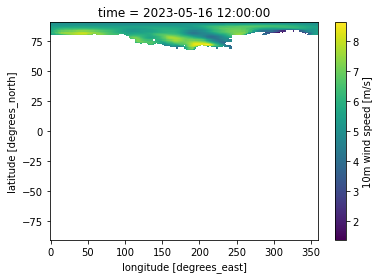

In [19]:
# test simple plot
data_masked.isel(time=100).plot()

In [20]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

Text(0.5, 1.0, 'No cartopy land')

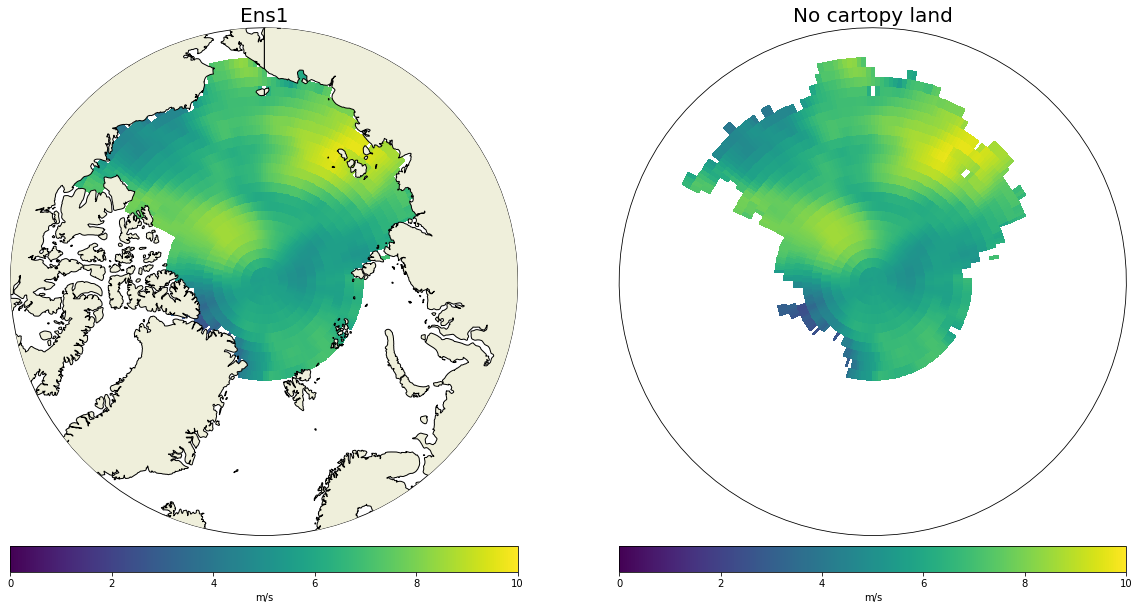

In [22]:
#Plot each season and difference
vmax_in = 10
vmin_in = 0
cmap_in = plt.cm.get_cmap('viridis')

# create figure
fig = plt.figure(figsize=(20,20))
    
# grab data we want to plot
temp1 = data_masked.isel(time=10)

# add cyclic points
temp1 = gvutil.xr_add_cyclic_longitudes(temp1,"lon")

# Make subplots - note it's nrow x ncol x index (starting upper left)
# First subplot
ax = fig.add_subplot(1,2,1, projection=ccrs.NorthPolarStereo())
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
this=ax.pcolormesh(temp1.lon,temp1.lat,
                       temp1,
                       cmap=cmap_in,vmax=vmax_in,vmin=vmin_in,
                       transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='horizontal',label=units,fraction=0.04,pad=0.01)
plt.title('Ens1',fontsize=20)

# Second subplot
ax = fig.add_subplot(1,2,2, projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
this=ax.pcolormesh(temp1.lon,temp1.lat,
                       temp1,
                       cmap=cmap_in,vmax=vmax_in,vmin=vmin_in,
                       transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='horizontal',label=units,fraction=0.04,pad=0.01)
plt.title('No cartopy land',fontsize=20)
     

## Save as a netcdf

In [23]:
fout = 'ATM_MASK_ArcOc'

In [27]:
# set some info for output
longname = 'mask'
units = ' '

In [28]:
ds_to_save = xr.Dataset({'atm_ArcOc_mask': (['lat','lon'], atm_ArcOc_mask.data)},
                        coords={'lat':(['lat'],atm_ArcOc_mask.lat.values),
                                'lon':(['lon'],atm_ArcOc_mask.lon.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [29]:
# double check dataset we plan to save
ds_to_save

<xarray.Dataset>
Dimensions:         (lat: 192, lon: 288)
Coordinates:
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    atm_ArcOc_mask  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
Attributes:
    Author:    Alice DuVivier
    units:      
    longname:  mask

In [31]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file